# Downloading The Dataset

In [1]:
%pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dog-and-cat-classification-dataset


In [2]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

In [43]:
path = '/kaggle/input/dog-and-cat-classification-dataset'

In [44]:
folders = []
for folder in os.listdir(os.path.join(path)):
    print(f"File: {folder}")
    folders.append(folder)

File: PetImages


In [45]:
subFolders = []
for folder in folders:
  for file in os.listdir(os.path.join(path, folder)):
      print(f"File: {file}")
      subFolders.append(file)

File: Dog
File: Cat


In [46]:
dogs = os.listdir(os.path.join(path, folders[0], subFolders[0]))
cats = os.listdir(os.path.join(path, folders[0], subFolders[1]))

## Lets Check for Data Balance!

In [47]:
dogCount = len(dogs)
catCount = len(cats)
print(f"Total Dogs: {dogCount}")
print(f"Total Cats: {catCount}")

Total Dogs: 12499
Total Cats: 12499


# Initialize The Class Map (0 => **Cat**, 1 => **Dog** )

In [156]:
petMap = {1: "Dog", 0: "Cat"}

# **Check How Balanced The Dataset is**

In [57]:
writablePath = '/content'
train = os.path.join(writablePath, 'train')
print(f"Training Path: {train}")

test = os.path.join(writablePath, 'test')
print(f"Training Path: {train}")


if not os.path.exists(train):
    os.makedirs(train)

if not os.path.exists(test):
    os.makedirs(test)

Training Path: /content/train
Training Path: /content/train


In [58]:
os.listdir(os.path.join(writablePath))

['.config', 'test', 'train', 'sample_data']

In [59]:
os.listdir(path)

['PetImages']

# Data Preparation

In [ ]:
import random
import shutil
pets = ['Dog', 'Cat']
chosenPet = ''
petsPath = [os.path.join(path, folders[0], pets[0]), os.path.join(path, folders[0], pets[1])]
np.random.seed(42)

print(petsPath)
for pet in pets:
    os.makedirs(os.path.join(test, pet), exist_ok=True)
    os.makedirs(os.path.join(train, pet), exist_ok=True)


for pet_path in petsPath:

  if pet_path.endswith('Dog'):
    chosenPet = pets[0]
  else:
    chosenPet = pets[1]

  images = [f for f in os.listdir(pet_path) if os.path.isfile(os.path.join(pet_path, f))]
  print(f"Len of{chosenPet} : {len(images)}" )


  random.shuffle(images)
  total_len = len(images)

  trainLen = int(total_len * 0.8)
  testLen = int(total_len - trainLen)

  trainImgs = images[:trainLen]
  testImgs = images[trainLen:]


  for img in trainImgs:
      shutil.copy2(os.path.join(pet_path, img), os.path.join(train, chosenPet, img))
      print(img," Moved to", train)
  for img in testImgs:
      shutil.copy2(os.path.join(pet_path, img), os.path.join(test, chosenPet, img))
      print(img," Moved to", test)


# **Splitting each Split into two Classes Male and Female**

In [72]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TrainDataGen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    shear_range = 0.15,
    validation_split = 0.2
    )

ValDataGen = ImageDataGenerator(
    rescale=1./255,
    validation_split = 0.2
)
TestDataGen = ImageDataGenerator(
    rescale=1./255,
)


In [92]:
Width, Height = 224, 224
batchSize = 64
channelLen = 3

TrainSet = TrainDataGen.flow_from_directory(
    train,
    target_size=(Width, Height),
    batch_size=batchSize,
    class_mode='binary',
    shuffle=True,
    color_mode ='rgb'
)
ValSet = ValDataGen.flow_from_directory(
    train,
    target_size=(Width, Height),
    batch_size=batchSize,
    class_mode='binary',
    color_mode ='rgb',
    subset="validation",
    shuffle = False
)
TestSet = TestDataGen.flow_from_directory(
    test,
    target_size=(Width, Height),
    batch_size=batchSize,
    class_mode='binary',
    shuffle=True,
    color_mode ='rgb'
)

Found 19998 images belonging to 2 classes.
Found 3998 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# **Libraries Needed For Transfer Learning**

In [93]:
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import ExponentialDecay

## Initializing Our Pretrained Model

In [94]:
pretrainedModel = VGG16(include_top=False, weights="imagenet", input_shape=(Width, Height, channelLen))

### Set The last 3 layers to be finetuned

In [ ]:
for layer in pretrainedModel.layers:
    layer.trainable = False
for layer in pretrainedModel.layers[-3:]:
    layer.trainable = True

In [95]:
model = Sequential()

model.add(pretrainedModel)

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

In [96]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
modelCheckpoint = ModelCheckpoint('bestModel.keras', monitor='val_loss', save_best_only=True)
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
adam = Adam(learning_rate= lr_schedule)

In [97]:
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [98]:
hist = model.fit(x=TrainSet,
                validation_data=ValSet,
                epochs=10,
                callbacks=[earlyStopping, modelCheckpoint],
                verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
165/313 ━━━━━━━━━━━━━━━━━━━━ 2:07 863ms/step - accuracy: 0.7547 - loss: 0.7571

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


313/313 ━━━━━━━━━━━━━━━━━━━━ 320s 942ms/step - accuracy: 0.8033 - loss: 0.5750 - val_accuracy: 0.9357 - val_loss: 0.1697
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 298s 939ms/step - accuracy: 0.9283 - loss: 0.1790 - val_accuracy: 0.9527 - val_loss: 0.1163
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 292s 934ms/step - accuracy: 0.9460 - loss: 0.1440 - val_accuracy: 0.9687 - val_loss: 0.0905
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 290s 925ms/step - accuracy: 0.9471 - loss: 0.1306 - val_accuracy: 0.9680 - val_loss: 0.0924
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 286s 912ms/step - accuracy: 0.9619 - loss: 0.1091 - val_accuracy: 0.9745 - val_loss: 0.0792
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 289s 922ms/step - accuracy: 0.9653 - loss: 0.0943 - val_accuracy: 0.9730 - val_loss: 0.0642
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 291s 929ms/step - accuracy: 0.9642 - loss: 0.0963 - val_accuracy: 0.9822 - val_loss: 0.0489
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 293s 936ms/step - accuracy: 0.9687 - loss: 0.08

In [99]:
hist

In [107]:
accuracy = hist.history['accuracy']
valAccuracy = hist.history['val_accuracy']
loss = hist.history['loss']
valLoss = hist.history['val_loss']

## Train Insights

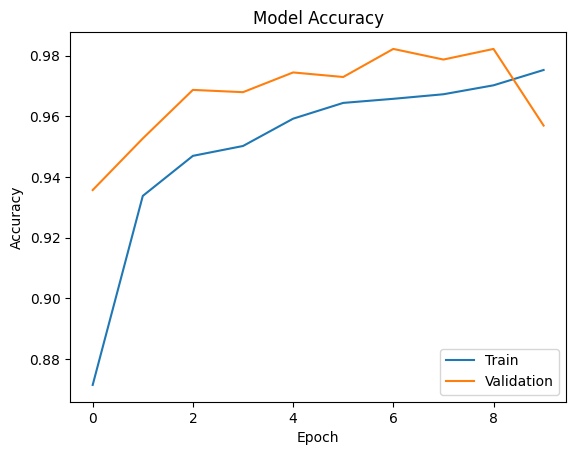

In [111]:
plt.plot(accuracy)
plt.plot(valAccuracy)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

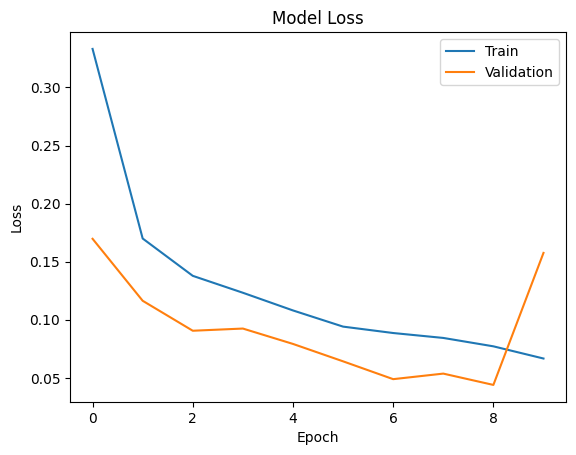

In [118]:
plt.plot(loss)
plt.plot(valLoss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

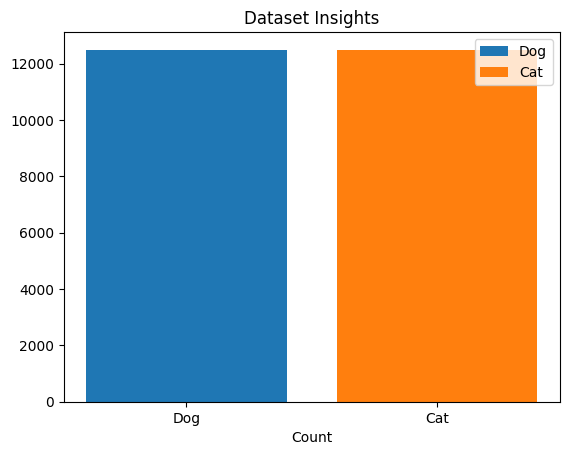

In [123]:
plt.bar('Dog',dogCount)
plt.bar('Cat',catCount)
plt.title('Dataset Insights')
plt.xlabel('Count')
plt.legend(['Dog', 'Cat'], loc='upper right')
plt.show()

In [132]:
print(f"The Fine-Tuned Model achieved {int(round(eval[1],2)*100)}% Validation Accuracy")
print(f"The Fine-Tuned Model Loss => {int(round(eval[0],2)*100)}%")

The Fine-Tuned Model achieved 97% Validation Accuracy
The Fine-Tuned Model Loss => 9%


# Lets Test on Image Samples!

In [114]:
eval = model.evaluate(TestSet)

79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 274ms/step - accuracy: 0.9668 - loss: 0.0844


In [133]:
preds = model.predict(TestSet)

79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 273ms/step


In [134]:
preds

array([[9.4184357e-01],
       [1.0000000e+00],
       [9.4764143e-01],
       ...,
       [7.5682021e-09],
       [1.0000000e+00],
       [1.2529578e-05]], dtype=float32)

In [144]:
testImgs, labels = next(TestSet)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


/tmp/ipython-input-171-2841109385.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(f"Actual: {petMap[int(actualLabels[i])]}\nPred: {petMap[int(predictedLabels[i])]}")


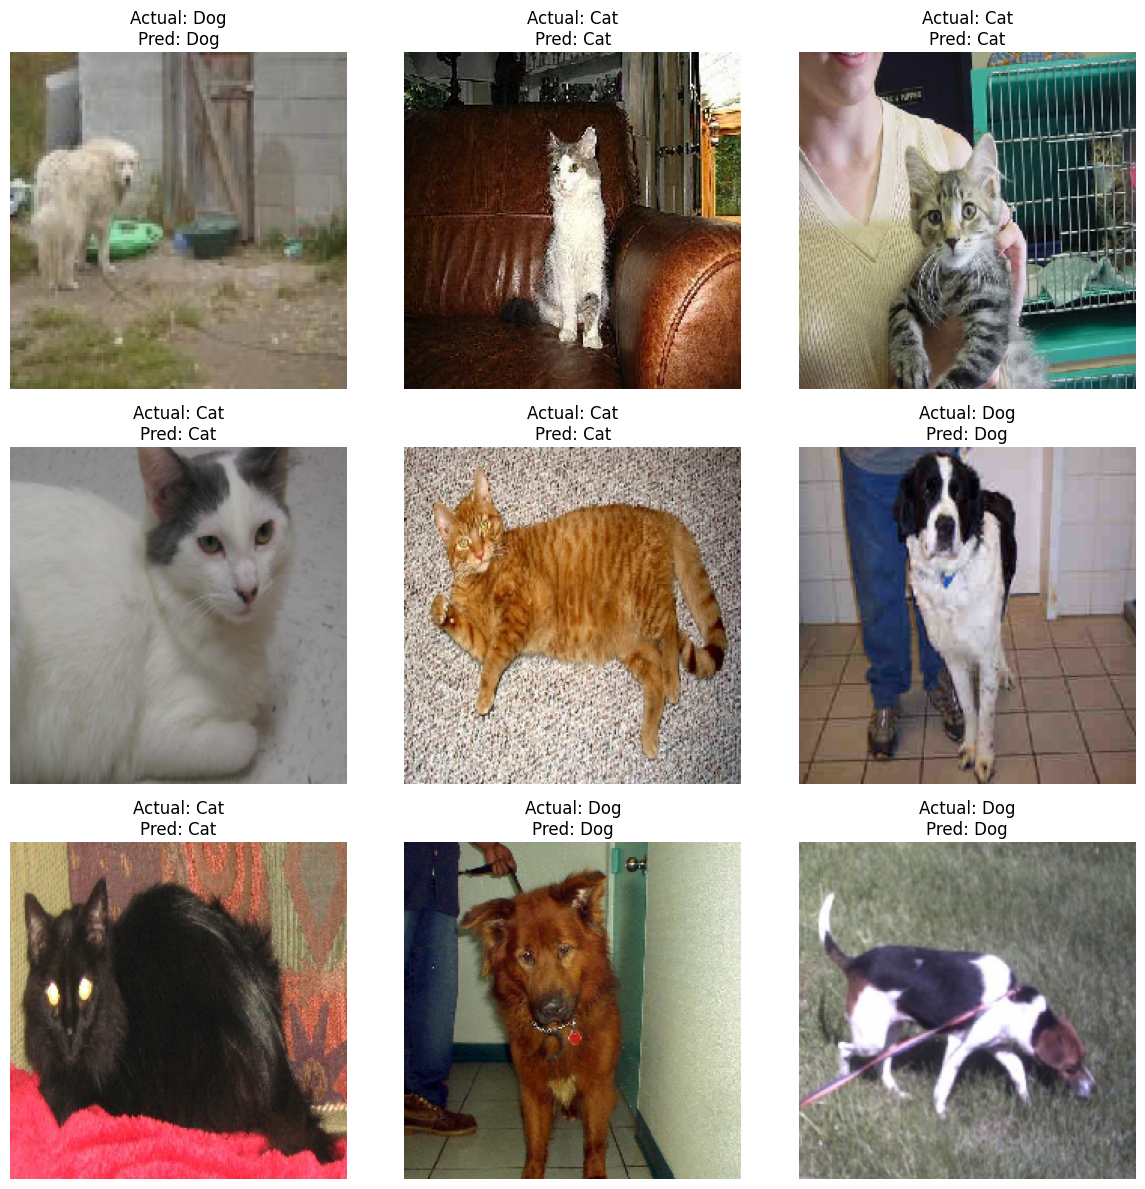

In [171]:
images, labels = next(TestSet)

np.random.seed(42)
random_indices = np.random.choice(len(images), size=9, replace=False)

testImages = images[random_indices]
actualLabels = labels[random_indices]

predictions = model.predict(testImages)
predictedLabels = np.round(predictions).astype(int)

petMap = {0: 'Cat', 1: 'Dog'}

rows = 3
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
axes = axes.flatten()

for i in range(len(testImages)):
    row = i % rows
    col = i // rows
    idx = row + col * rows
    ax = axes[idx]
    ax.imshow(testImages[i])
    ax.set_title(f"Actual: {petMap[int(actualLabels[i])]}\nPred: {petMap[int(predictedLabels[i])]}")
    ax.axis('off')

for j in range(len(testImages), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


# **Thank You! See You in the Next Project :)**